In [1]:
import xarray as xr 
s1 = xr.open_rasterio('/Users/rricker/Data/IS2/S1/S1_EW_HH_sub_20200323T102552_20200323T102857_s1_400km_ps_50m_50.tiff')

import sys
sys.path.append('/Users/rricker/GitLab/projects/chione/')
out_path = "/Users/rricker/OneDrive - NORCE/publications/2022/ICESat2_ALS_MOSAiC/"
import pandas as pd
import geopandas as gpd
import shapely as shp
import numpy as np
import xarray as xr 
import netCDF4
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.time import Time
from scipy import interpolate
from scipy.interpolate import Rbf
from scipy import signal
from PIL import Image
from read_icesat2.read_ICESat2_ATL07 import read_HDF5_ATL07
from read_icesat2.read_ICESat2_ATL10 import read_HDF5_ATL10
import warnings
import cartopy.crs as ccrs
import cartopy
from matplotlib.colors import LightSource
from matplotlib import ticker
import glob
import logging, sys
from datetime import date
import datetime 
from multiprocessing.pool import Pool
from astropy.time import Time
from tqdm.notebook import tqdm
from pyproj import Proj, transform
from pyproj import CRS
import gps_time
import re
import json
import pickle
import statistics as stat
import os
import geopy.distance
import cmocean
from scipy.interpolate import griddata
from geographiclib.geodesic import Geodesic
from shapely.geometry import Point, LineString
from shapely.geometry.polygon import LinearRing
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import seaborn as sns
from math import degrees, atan2
from scipy.stats import lognorm
from scipy.optimize import curve_fit

warnings.filterwarnings('ignore')
logging.disable(sys.maxsize)
warnings.filterwarnings("ignore")

In [50]:
def set_violin_plot_peak_shift(arr):
    bin_size=0.01
    rmin, rmax = np.min(arr), np.max(arr)
    bins = int(np.round((rmax-rmin)/bin_size))
    counts, edges = np.histogram(arr,range=(rmin, rmax), bins = bins )
    bin_center = edges[:-1]+ bin_size
    return bin_center[np.argmax(counts)]

def set_violin_plot(df):
    correction_ALS, correction_ATL = remove_undulations(df,720)
    ALS_seg = np.array(df.ALS_elevation-correction_ALS)
    ATL_seg = np.array(df.ATL_elevation-correction_ATL)
    valid = np.where(np.isnan(ALS_seg)==False)[0]   
    tmp = []
    for i in valid:
        tmp.append(df.pointsinside[i].elevation-correction_ALS[i])
    ALS_all = pd.concat([gdf for gdf in tmp]).pipe(gpd.GeoDataFrame)
    
    ALS_seg = ALS_seg[valid] - set_violin_plot_peak_shift(ALS_seg[valid])
    ATL_seg = ATL_seg[valid] - set_violin_plot_peak_shift(ATL_seg[valid])
    ALS_all = np.array(ALS_all.elevation) - set_violin_plot_peak_shift(np.array(ALS_all.elevation))
    
    return ALS_seg, ATL_seg, ALS_all

def set_violin_plot_merge_beams(gt2l,gt2r,label):
    arr = np.concatenate((gt2l,gt2r))    
    beam_r = np.empty(len(gt2r),dtype=object)
    beam_r[:]="gt2r"
    beam_l = np.empty(len(gt2l),dtype=object)
    beam_l[:]='gt2l'
    beam = np.concatenate((beam_l,beam_r))   

    set_label = np.empty(len(beam),dtype=object)
    set_label[:] = label

    data = {
        "Label":set_label,
        "Data": arr,
        "Beam": beam}
    return pd.DataFrame.from_dict(data)

def remove_undulations(df,window):
    # window of ca 720 samples corresponds to about 5 km
    grad = np.gradient(df.distance_along_track)
    section_list = (df.index[grad > 500].tolist())
    section_list.insert(0,0)
    section_list.append(df.index[-1])
    start = section_list[::2]
    end = section_list[1::2]

    correction_ALS = []
    correction_ATL = []

    for i in range(0,len(start)):
        correction_ALS.append(np.array(df.ALS_elevation[start[i]:end[i]+1].rolling(window,center=True,win_type='gaussian').mean(std=100)))
        correction_ATL.append(np.array(df.ATL_elevation[start[i]:end[i]+1].rolling(window,center=True,win_type='gaussian').mean(std=100)))
   
    correction_ALS = np.concatenate( correction_ALS, axis=0 )
    correction_ATL = np.concatenate( correction_ATL, axis=0 )    

    return correction_ALS, correction_ATL

def get_stats(df):

    ALS_hist_mean = []
    ALS_hist_mode = []
    ALS_hist_sdev = []
    ATL_hist_mean = []
    ATL_hist_sdev = []

    for i in range(0,len(df)):
        n_bin = len(df.hist_photon_heights[i])
        bin_size = df.hist_photon_bin_size[i]

        ALS_elev = np.array(df.pointsinside[i].elevation) 
        ALS_bin_center =  np.arange(n_bin) * bin_size + min(ALS_elev) - n_bin/4*bin_size
        ALS_bin_edges = np.append(ALS_bin_center-bin_size/2,max(ALS_bin_center)+bin_size/2)
        ALS_counts, _ = np.histogram(ALS_elev, bins=ALS_bin_edges, density=True)
        ALS_hist_mean.append(np.mean(ALS_elev))
        ALS_hist_mode.append(ALS_bin_center[np.argmax(ALS_counts)])
        ALS_hist_sdev.append(np.std(ALS_elev))

        ATL_bin_center = np.arange(n_bin)*bin_size + df.hist_photon_bottom[i]
        ATL_counts = np.array(df.hist_photon_heights[i])
        hist_mean = np.average(ATL_bin_center, weights=ATL_counts)
        hist_sdev = np.sqrt(np.average((ATL_bin_center - hist_mean)**2, weights=ATL_counts))
        ATL_hist_mean.append(hist_mean)
        ATL_hist_sdev.append(hist_sdev)
    
    return np.array(ALS_hist_sdev), np.array(df.hist_w)

def log_fit( x, c, theta, mu, sigma ):
    return c / (x-theta) * 1. /(sigma * np.sqrt( 2. * np.pi ) ) * np.exp( -( np.log( (x-theta) ) - mu )**2 / ( 2. * sigma**2 ) )

def log_param(mu,sigma):
    mean = np.exp(mu+sigma**2/2)
    mode = np.exp(mu-sigma**2)
    var = (np.exp(sigma**2-1))*np.exp(2*mu+sigma**2)
    skew = (np.exp(sigma**2)+2) * np.sqrt(np.exp(sigma**2)-1)
        
    return np.array([mean,mode,var,skew])

def reproject(x, y, in_epsg, out_epsg):
    inProj = Proj(init = in_epsg)
    outProj = Proj(init = out_epsg)
    xout,yout = transform(inProj,outProj,x,y)
    return xout,yout

def segment_coordinates(lon0,lat0,lon1,lat1,seg_length):
    bearing = Geodesic.WGS84.Inverse(lat0,lon0,lat1,lon1)['azi1']
    end = geopy.distance.distance(meters=seg_length/2).destination((lat0,lon0), bearing=bearing)
    start = geopy.distance.distance(meters=seg_length/2).destination((lat0,lon0), bearing=bearing+180.0)
    return start[0:2], end[0:2] 

def ATL07_h5_to_gdf(file_list):
    atlas_sdp_gps_epoch = 1198800018.0
    gdf_list=list()
    for file in file_list:
        IS2_atl07_mds,IS2_atl07_attrs,IS2_atl07_beams = read_HDF5_ATL07(file)
        beam_list = list()
        for beam in IS2_atl07_beams:    
            tmp = pd.DataFrame.from_dict(IS2_atl07_mds[beam]['sea_ice_segments']['geophysical'])
            tmp['height_segment_height'] = IS2_atl07_mds[beam]['sea_ice_segments']['heights']['height_segment_height']
            tmp['height_segment_length_seg'] = IS2_atl07_mds[beam]['sea_ice_segments']['heights']['height_segment_length_seg']
            tmp['height_segment_n_pulse_seg_used'] = IS2_atl07_mds[beam]['sea_ice_segments']['heights']['height_segment_n_pulse_seg_used']            
            tmp['height_segment_ssh_flag'] = IS2_atl07_mds[beam]['sea_ice_segments']['heights']['height_segment_ssh_flag']
            tmp['hist_photon_heights'] = IS2_atl07_mds[beam]['sea_ice_segments']['stats']['hist_photon_heights'].tolist()  
            tmp['hist_mean_h'] = IS2_atl07_mds[beam]['sea_ice_segments']['stats']['hist_mean_h']   
            tmp['hist_median_h'] = IS2_atl07_mds[beam]['sea_ice_segments']['stats']['hist_median_h']   
            tmp['hist_photon_bin_size'] = IS2_atl07_mds[beam]['sea_ice_segments']['stats']['hist_photon_bin_size']   
            tmp['hist_photon_bottom'] = IS2_atl07_mds[beam]['sea_ice_segments']['stats']['hist_photon_bottom']   
            tmp['hist_photon_top'] = IS2_atl07_mds[beam]['sea_ice_segments']['stats']['hist_photon_top']   
            tmp['hist_w'] = IS2_atl07_mds[beam]['sea_ice_segments']['stats']['hist_w']   
            tmp['delta_time'] = IS2_atl07_mds[beam]['sea_ice_segments']['delta_time']
            tmp['longitude']= IS2_atl07_mds[beam]['sea_ice_segments']['longitude']
            tmp['latitude']= IS2_atl07_mds[beam]['sea_ice_segments']['latitude']
            tmp['height_segment_id'] = IS2_atl07_mds[beam]['sea_ice_segments']['height_segment_id']
            tmp['beam'] = beam
            beam_list.append(tmp)
        
        df = pd.concat([df for df in beam_list]).pipe(gpd.GeoDataFrame)
        gdf = gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.longitude, df.latitude),crs=4326)
        gdf = gdf.to_crs(3413)
        gdf_list.append(gdf)   
                        
    gdf_final = pd.concat([gdf for gdf in gdf_list]).pipe(gpd.GeoDataFrame)    
    gdf_final['ATL_time'] = Time(gdf_final.delta_time+atlas_sdp_gps_epoch, format='gps').to_datetime()
    gdf_final.crs = (gdf_list[0].crs)
        
    return gdf_final.reset_index(drop=True)

def ATL10_h5_to_gdf(file_list):
    gdf_list=list()
    for file in file_list:
        IS2_atl10_mds,IS2_atl10_attrs,IS2_atl10_beams = read_HDF5_ATL10(file)
        beam_list = list()
        for beam in IS2_atl10_beams:    
            tmp = pd.DataFrame.from_dict(IS2_atl10_mds[beam]['freeboard_beam_segment']['beam_freeboard'])
            tmp['height_segment_ssh_flag'] = IS2_atl10_mds[beam]["freeboard_beam_segment"]["height_segments"]["height_segment_ssh_flag"]
            tmp['height_segment_type'] = IS2_atl10_mds[beam]["freeboard_beam_segment"]["height_segments"]["height_segment_type"]
            tmp['photon_rate'] = IS2_atl10_mds[beam]["freeboard_beam_segment"]["height_segments"]["photon_rate"]
            tmp['backgr_r_200'] = IS2_atl10_mds[beam]["freeboard_beam_segment"]["height_segments"]['backgr_r_200']
            tmp['asr_25'] = IS2_atl10_mds[beam]["freeboard_beam_segment"]["height_segments"]['asr_25']
            tmp['beam'] = beam
            beam_list.append(tmp)
            
        df = pd.concat([df for df in beam_list]).pipe(gpd.GeoDataFrame)
        gdf = gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.longitude, df.latitude),crs=4326)
        gdf = gdf.to_crs(3413)
        gdf_list.append(gdf)   
                        
    gdf_final = pd.concat([gdf for gdf in gdf_list]).pipe(gpd.GeoDataFrame)
    gdf_final.crs = (gdf_list[0].crs)
        
    return gdf_final.reset_index(drop=True)
    

def ALS_to_gdf(file_list):
    gdf_list=list()
    for file in file_list:
        print(file)
        ds = xr.open_dataset(file)
        ds = ds.drop_dims(["time","time_bnds","grid_mapping"])
        df = ds.to_dataframe()
        gdf = gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.lon, df.lat),crs=4326)
        gdf = gdf.to_crs(3413)
        gdf_list.append(gdf)   

    gdf_final = pd.concat([gdf for gdf in gdf_list]).pipe(gpd.GeoDataFrame)
    gdf_final.crs = (gdf_list[0].crs)
        
    return gdf_final.reset_index(drop=True)

def cbLike_to_csv(path_in, path_out):
    ALSlist = sorted(glob.glob(path_in + '*.nc'))
    cb_list=[]
    for file in ALSlist:
        gdf_final = ALS_to_gdf([file])
        gdf_final = gdf_final.dropna(how='any')
        gdf_final = gdf_final.sort_values(by=['timestamp']).reset_index(drop=True)
        d = {'lon': gdf_final.lon.rolling(5000, min_periods=1).mean()[30000:-30000:10000].reset_index(drop=True),
             'lat': gdf_final.lat.rolling(5000, min_periods=1).mean()[30000:-30000:10000].reset_index(drop=True),
             'ALS_time':pd.to_datetime(gdf_final.timestamp.rolling(5000, min_periods=1).mean()[30000:-30000:10000].reset_index(drop=True), unit='s'),
             'elevation':gdf_final.elevation.rolling(5000, min_periods=1).mean()[30000:-30000:10000].reset_index(drop=True)}
        cb_list.append(pd.DataFrame(data=d))

    cbLike = pd.concat([gdf for gdf in cb_list]).pipe(gpd.GeoDataFrame)
    cbLike.to_csv('/Users/rricker/Data/IS2/cbLike_track.csv',index=False)

def drift_corr_ALS(ALS_gdf,ATL07_gdf):
    # drift correction in m/s on polarstereographic grid
    dx, dy = 0.01773, 0.00094
    dt = (ALS_gdf.ALS_time-np.mean(ATL07_gdf.ATL_time)).dt.total_seconds()

    xn = ALS_gdf.geometry.x - (dt * dx)
    yn = ALS_gdf.geometry.y - (dt * dy)
    return gpd.GeoDataFrame(ALS_gdf, geometry=gpd.points_from_xy(xn, yn)), np.mean(dt)
    
def join_ATL_ALS(ALSlist,ATL07_gdf,ATL10_gdf):
    data_list = list()
    
    for j in range(0,len(ALSlist)):
        # load 2 subsequent ALS grids to ensure overlap, to avoid only partially filled ATL foorptints,
        # duplicates will be deleted
        ALS_gdf = ALS_to_gdf(ALSlist[j:j+2])
        ALS_gdf = ALS_gdf[np.isnan(ALS_gdf.elevation)!=True].reset_index(drop=True)
        ALS_gdf['ALS_time'] = pd.to_datetime(ALS_gdf['timestamp'], unit='s')

        ATL07_gdfs = ATL07_gdf[(ATL07_gdf["latitude"]<ALS_gdf["lat"].max()) &
                               (ATL07_gdf["latitude"]>ALS_gdf["lat"].min()) &
                               (ATL07_gdf["longitude"]<ALS_gdf["lon"].max()) &
                               (ATL07_gdf["longitude"]>ALS_gdf["lon"].min())].reset_index(drop=True)
        
        if ATL07_gdfs.empty: continue
        ATL07_gdfs.crs = 4326

        ATL10_gdfs = ATL10_gdf[(ATL10_gdf["latitude"]<ALS_gdf["lat"].max()) &
                               (ATL10_gdf["latitude"]>ALS_gdf["lat"].min()) &
                               (ATL10_gdf["longitude"]<ALS_gdf["lon"].max()) &
                               (ATL10_gdf["longitude"]>ALS_gdf["lon"].min())].reset_index(drop=True)

        
        _add = pd.DataFrame(data=ATL10_gdfs,columns=['beam_fb_height','beam_fb_quality_flag','beam_fb_confidence',
                                            'height_segment_ssh_flag','height_segment_type','photon_rate',
                                            'backgr_r_200','asr_25'])

        ATL07_gdfs = pd.concat([ATL07_gdfs,_add], axis=1)
        
        
        atl10_list=[]
        for l in range(0,len(ATL07_gdfs)):
            atl10_list.append(ATL10_gdfs[(ATL10_gdfs.beam == ATL07_gdfs.beam[l]) &
                                         (ATL10_gdfs.height_segment_id == ATL07_gdfs.height_segment_id[l])])

        ATL10_gdfs = pd.concat([gdf for gdf in atl10_list]).pipe(gpd.GeoDataFrame)        
        
        # ALS drift correction
        ALS_gdf, mean_dt = drift_corr_ALS(ALS_gdf,ATL07_gdfs)
        print(mean_dt)
        
        seg_start =[]
        seg_end =[]
        Linestr = []
        for i in range(0,len(ATL07_gdfs)):
            
            if i < len(ATL07_gdfs)-1:
                ps, pe = segment_coordinates(ATL07_gdfs.longitude[i],ATL07_gdfs.latitude[i],
                                             ATL07_gdfs.longitude[i+1],ATL07_gdfs.latitude[i+1],
                                             ATL07_gdfs.height_segment_length_seg[i])
            else:
                ps, pe = segment_coordinates(ATL07_gdfs.longitude[i],ATL07_gdfs.latitude[i],
                                             ATL07_gdfs.longitude[i-1],ATL07_gdfs.latitude[i-1],
                                             ATL07_gdfs.height_segment_length_seg[i])

            seg_start.append(ps)
            seg_end.append(pe)
            Linestr.append(LineString([(ps[1],ps[0]),(pe[1],pe[0])]))

        ATL07_gdfs['segment_start'] = seg_start
        ATL07_gdfs['segment_end'] = seg_end
        ATL07_gdfs['segment_center_point'] = ATL07_gdfs['geometry']
        ATL07_gdfs['geometry'] = Linestr
        ATL07_gdfs = ATL07_gdfs.to_crs("EPSG:3413")
        ATL07_gdfs["geometry"] = ATL07_gdfs.geometry.buffer(6.5)
        footprint = gpd.GeoDataFrame(crs=3413, geometry=ATL07_gdfs["geometry"] )
        pointsinside = gpd.sjoin(ALS_gdf,footprint,how="inner").reset_index(drop=True)

        ALS=pointsinside.groupby(pointsinside.index_right).mean()
        ALS['n_points'] = pointsinside.groupby(pointsinside.index_right).elevation.count() 
        ALS.reset_index(inplace=True)

        ALS['pointsinside']=''
        ALS['n_pointsinside']=''
        
        for i in ALS.index_right.unique():
            tmp = pointsinside[pointsinside.index_right==i].drop(['index_right',
                                                                  'timestamp',
                                                                  'ALS_time',
                                                                  'n_points',
                                                                  'elevation_reference',
                                                                  'echo_width'],axis=1).reset_index(drop=True)
            ALS.pointsinside[ALS.index[ALS.index_right==i][0]] = tmp
            ALS.n_pointsinside[ALS.index[ALS.index_right==i][0]] = tmp.elevation.count()

        ALS.insert(1, 'ALS_time', pd.to_datetime(ALS['timestamp'], unit='s'))
            
        ATL=ATL07_gdfs.iloc[ALS.index_right.unique()].reset_index(drop=True)
        ALS = ALS[['ALS_time','elevation','elevation_reference','reflectance',
                   'echo_width','freeboard','pointsinside','n_pointsinside']]
        ALS.rename(columns={"elevation": "ALS_elevation",
                            "elevation_reference": "ALS_elevation_reference",
                            "freeboard": "ALS_freeboard",
                            "reflectance": "ALS_reflectance",
                            "echo_width": "ALS_echo_width"},inplace=True)
        
        ATL = ATL[['ATL_time','height_segment_height','beam_fb_height','height_segment_id',
                   'height_segment_length_seg','height_segment_n_pulse_seg_used','beam_fb_quality_flag',
                   'beam_fb_confidence','height_segment_ssh_flag','height_segment_type','photon_rate',
                   'backgr_r_200','asr_25',
                   'hist_photon_heights','hist_photon_bin_size','hist_photon_bottom','hist_photon_top',
                   'hist_mean_h','hist_median_h','hist_w',
                   'longitude','latitude','beam','segment_center_point','geometry']]
        
        ATL.rename(columns={"height_segment_height": "ATL_elevation"},inplace=True)
        data_list.append(pd.concat([ATL, ALS], axis=1).sort_values(by=['ALS_time'])[20:-20])

        del ALS_gdf, ATL07_gdfs, ATL10_gdfs, ALS, ATL, footprint, pointsinside

    data = pd.concat([gdf for gdf in data_list]).pipe(gpd.GeoDataFrame)

    data_gt2l = data[data["beam"]=='gt2l'].reset_index(drop=True).sort_values(by=['ALS_time']).reset_index(drop=True)  
    data_gt2l.drop_duplicates(subset=['height_segment_id'], keep='first', inplace=True)
    data_gt2l = data_gt2l[(data_gt2l['n_pointsinside'] > 2500)]
    data_gt2l.reset_index(drop=True, inplace=True)
                          
    data_gt2r = data[data["beam"]=='gt2r'].reset_index(drop=True).sort_values(by=['ALS_time']).reset_index(drop=True)
    data_gt2r.drop_duplicates(subset=['height_segment_id'], keep='first', inplace=True)
    data_gt2r = data_gt2r[(data_gt2r['n_pointsinside'] > 1000)]
    data_gt2r.reset_index(drop=True, inplace=True)

    tmp = gpd.GeoDataFrame(geometry=data_gt2l.segment_center_point)
    data_gt2l['distance_along_track'] = tmp.distance(tmp.shift(1)).cumsum(axis = 0)
    data_gt2l['distance_along_track'][0]=0
    tmp = gpd.GeoDataFrame(geometry=data_gt2r.segment_center_point)
    data_gt2r['distance_along_track'] = tmp.distance(tmp.shift(1)).cumsum(axis = 0)
    data_gt2r['distance_along_track'][0]=0
    
    return data_gt2l, data_gt2r

def get_ALS_ssh(ALSlist):
    ssh_list = list()

    for file in ALSlist:
        ALS_gdf = ALS_to_gdf([file])
        ALS_gdf = ALS_gdf.dropna(how='any').reset_index(drop=True)
        ALS_gdf = ALS_gdf[ALS_gdf.elevation < ALS_gdf.elevation.quantile(.10)]
        ALS_ssh = ALS_gdf[ALS_gdf.reflectance < -12]
        if len(ALS_ssh)!=0: 
            ALS_ssh[(ALS_ssh.elevation > ALS_ssh.elevation.quantile(.25))&
                    (ALS_ssh.elevation < ALS_ssh.elevation.quantile(.75))]
            ALS_ssh
            if len(ALS_ssh)!=0: 
                ssh_list.append(ALS_ssh.mean().to_frame().T)

    ALS_ssh = pd.concat([gdf for gdf in ssh_list]).pipe(gpd.GeoDataFrame).reset_index(drop=True)
    ALS_ssh['ALS_time'] = pd.to_datetime(ALS_ssh.timestamp, unit='s')
    
    return ALS_ssh

def get_ALS_openwater(ow_file):
    ow = pd.read_csv(ow_file)
    ow['ALS_time'] = pd.to_datetime(ow['timestamp'], unit='s')
    return ow

def lag_finder(y1, y2, sr,figure=False):
    wl = round(len(y1)/2)
    y1 = y1-y1.rolling(wl,center=True).mean()
    y2 = y2-y2.rolling(wl,center=True).mean()
    
    y1 = y1.dropna()
    y2 = y2.dropna()
    
    n = len(y1)

    corr = signal.correlate(y2, y1, mode='same') / np.sqrt(signal.correlate(y1, y1, mode='same')[int(n/2)] * signal.correlate(y2, y2, mode='same')[int(n/2)])

    delay_arr = np.linspace(-0.5*n/sr, 0.5*n/sr, n)
    delay = delay_arr[np.argmax(corr)]
    
    if figure:
        plt.figure()
        plt.plot(delay_arr, corr,marker='*')
        plt.title('Lag: ' + str(np.round(delay, 3)) + ' s')
        plt.xlabel('Lag')
        plt.ylabel('Correlation coeff')
        plt.show()
    
    return delay, delay_arr, corr

def get_drift_corr(df,wl):
    dl_list = []
    at = []

    bearing_list=[]
    for i in range(0,len(df)):
        if i < len(df)-100:
            bearing_list.append(degrees(atan2(df.segment_center_point.y[i+1] - df.segment_center_point.y[i],
                                              df.segment_center_point.x[i+1] - df.segment_center_point.x[i])))
        else:
            bearing_list.append(degrees(atan2(df.segment_center_point.y[i] - df.segment_center_point.y[i-1],
                                              df.segment_center_point.x[i] - df.segment_center_point.x[i-1])))

    pdf=np.histogram(bearing_list,bins=200,range=(-10,10))
    bearing = pdf[1][np.argmax(pdf[0])] 

    for i in range(0,len(df)-wl):
        dl,dl_array,corr = lag_finder(df.ALS_elevation[i:i+wl], df.ATL_elevation[i:i+wl], 1)
        if np.max(corr) > 0.8: 
            dl_list.append(dl)
            at.append(df.ALS_time[i+wl/2].timestamp())

    #modal point to point distance    
    step = df.distance_along_track - df.distance_along_track.shift(periods=1)
    pdf=np.histogram(step,bins=200,range=(-10,10))
    point_dist = pdf[1][np.argmax(pdf[0])]   
    print(point_dist)

    coef = np.polyfit(at,dl_list,1)
    poly1d_fn = np.poly1d(coef) 

    dirft_mag = coef[0]*point_dist

    # meter/second
    dx = dirft_mag * np.cos(np.radians(bearing)) 
    dy = dirft_mag * np.sin(np.radians(bearing))

    return dx, dy, dl_list, poly1d_fn, coef, at

0.8937297908826408 0.9546572647828778 0.5269661744880568
0.0 0.0 0.0
-11.960529166666667 -0.9678565166666666 17.8115318


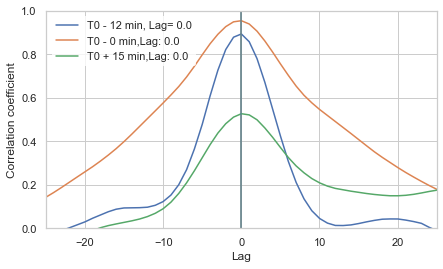

In [28]:
sns.set_theme(style="whitegrid")
i1=1400
i2=4850
i3=9900

df = data_gt2l
wl=1000
dl1,dl_array1,corr1 = lag_finder(df.ALS_elevation[i1:i1+wl], df.ATL_elevation[i1:i1+wl], 1)
dl2,dl_array2,corr2 = lag_finder(df.ALS_elevation[i2:i2+wl], df.ATL_elevation[i2:i2+wl], 1)
dl3,dl_array3,corr3 = lag_finder(df.ALS_elevation[i3:i3+wl], df.ATL_elevation[i3:i3+wl], 1)

dt1, dt2, dt3 =df.ALS_time[i1]-df.ATL_time[i1], df.ALS_time[i2]-df.ATL_time[i2], df.ALS_time[i3]-df.ATL_time[i3]

print(np.max(corr1), np.max(corr2), np.max(corr3))
print(dl1,dl2,dl3)
print(dt1.total_seconds()/60,dt2.total_seconds()/60,dt3.total_seconds()/60)

plt.figure(figsize=(7, 4))
plt.plot(dl_array1, corr1,label='T0 - 12 min, Lag= ' + str(np.round(dl1)))
plt.plot([np.round(dl1),np.round(dl1)],[0,1],color=sns.color_palette()[0],alpha=0.5)
plt.plot(dl_array2, corr2,label='T0 - 0 min,Lag: ' + str(np.round(dl2)))
plt.plot([np.round(dl2),np.round(dl2)],[0,1],color=sns.color_palette()[1],alpha=0.5)
plt.plot(dl_array3, corr3,label='T0 + 15 min,Lag: ' + str(np.round(dl3)))
plt.plot([np.round(dl3),np.round(dl3)],[0,1],color=sns.color_palette()[2],alpha=0.5)
plt.xlim((-25,25))
plt.ylim((0,1.0))
plt.xlabel('Lag')
plt.ylabel('Correlation coefficient')
legend = plt.legend(loc=2)
legend.get_frame().set_linewidth(0)

plt.plot([np.round(dl2),np.round(dl2)],[0,1],color=sns.color_palette()[0],alpha=0.5)

plt.savefig(out_path + 'Cross_correlation.png',dpi=300,bbox_inches='tight' )

In [5]:
%%time

#read ATL07 and write into geodataframe
ATL07file = list(["/Users/rricker/Data/IS2/ATL07-01_20200323105252_13400601_005_01.h5"])
ATL07_gdf = ATL07_h5_to_gdf(ATL07file)  

#read ATL010 and write into geodataframe
ATL10file = list(["/Users/rricker/Data/IS2/ATL10-01_20200323105252_13400601_005_02.h5"])
ATL10_gdf = ATL10_h5_to_gdf(ATL10file)  

CPU times: user 26.1 s, sys: 2.78 s, total: 28.9 s
Wall time: 31.8 s


In [4]:
%%time
#merge ATL07 and ALS, search for ALS data within ATL07 segments and calculate footprint 

ALSpath = "/Users/rricker/Data/IS2/tds-is2/l4-grid-v2/"
ALSlist = sorted(glob.glob(ALSpath + '*.nc'))
#ALSlist=ALSlist[64:68]

#data_gt2l, data_gt2r = join_ATL_ALS(ALSlist,ATL07_gdf,ATL10_gdf)

#data_gt2l.to_pickle('/Users/rricker/Data/IS2/data_gt2l_DriftCorrected_v3.pkl')
#data_gt2r.to_pickle('/Users/rricker/Data/IS2/data_gt2r_DriftCorrected_v3.pkl')

data_gt2l = pd.read_pickle('/Users/rricker/Data/IS2/data_gt2l_DriftCorrected_v3.pkl')
data_gt2r = pd.read_pickle('/Users/rricker/Data/IS2/data_gt2r_DriftCorrected_v3.pkl')
#data_gt2l = pd.read_pickle('/Users/rricker/Data/IS2/data_gt2l.pkl')
#data_gt2r = pd.read_pickle('/Users/rricker/Data/IS2/data_gt2r.pkl')

CPU times: user 14.3 s, sys: 3.64 s, total: 18 s
Wall time: 21.5 s


In [32]:
dx, dy = 0.018, 0.00094

dx_l, dy_l, dl_list_l, poly1d_fn_l, coef_l, at_l = get_drift_corr(data_gt2l,1000)
dx_r, dy_r, dl_list_r, poly1d_fn_r, coef_r, at_r = get_drift_corr(data_gt2r,1000)

dx = np.around((dx_l+dx_r)/2, decimals=5)
dy = np.around((dy_l+dy_r)/2, decimals=5)

print(dx)
print(dy)

7.300000000000001
7.300000000000001
0.0017
9e-05


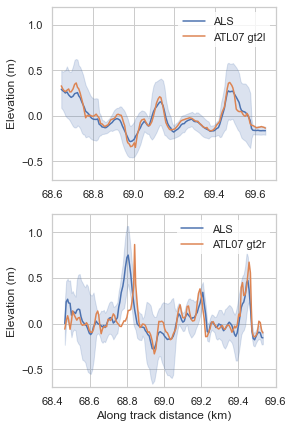

In [52]:
sns.set_theme(style="whitegrid")
correction_ALS, correction_ATL = remove_undulations(data_gt2l,720)
ALS_gt2l=data_gt2l.ALS_elevation-correction_ALS
ATL_gt2l=data_gt2l.ATL_elevation-correction_ATL
correction_ALS, correction_ATL = remove_undulations(data_gt2r,720)
ALS_gt2r=data_gt2r.ALS_elevation-correction_ALS
ATL_gt2r=data_gt2r.ATL_elevation-correction_ATL

fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(4, 7))
ax1.set_ylabel("Elevation (m)")
ax1.set_xlim(68.6,69.7)
ax1.set_ylim(-0.7,1.2)
ax1.fill_between(data_gt2l['distance_along_track'][3252:3389]/1000.0,
                 ALS_gt2l[3252:3389]-ALS_hist_sdev[3252:3389],
                 ALS_gt2l[3252:3389]+ALS_hist_sdev[3252:3389],color=sns.color_palette()[0],alpha=0.2)
ax1.plot(data_gt2l['distance_along_track'][3252:3389]/1000.0,ALS_gt2l[3252:3389],  label='ALS')
ax1.plot(data_gt2l['distance_along_track'][3252:3389]/1000.0,ATL_gt2l[3252:3389],  label='ATL07 gt2l')
legend = ax1.legend()
legend.get_frame().set_linewidth(0)

ax2.set_xlabel("Along track distance (km)")
ax2.set_ylabel("Elevation (m)")
ax2.set_xlim(68.4,69.6)
ax2.set_ylim(-0.7,1.2)
ax2.fill_between(data_gt2r['distance_along_track'][2306:2451]/1000.0,
                 ALS_gt2r[2306:2451]-ALS_hist_sdev[2306:2451],
                 ALS_gt2r[2306:2451]+ALS_hist_sdev[2306:2451],color=sns.color_palette()[0],alpha=0.2)
ax2.plot(data_gt2r['distance_along_track'][2306:2451]/1000.0,ALS_gt2r[2306:2451],  label='ALS')
ax2.plot(data_gt2r['distance_along_track'][2306:2451]/1000.0,ATL_gt2r[2306:2451],  label='ATL07 gt2r')
legend = ax2.legend()
legend.get_frame().set_linewidth(0)

plt.savefig(out_path + 'Overview2_2.png',dpi=300,bbox_inches='tight' )

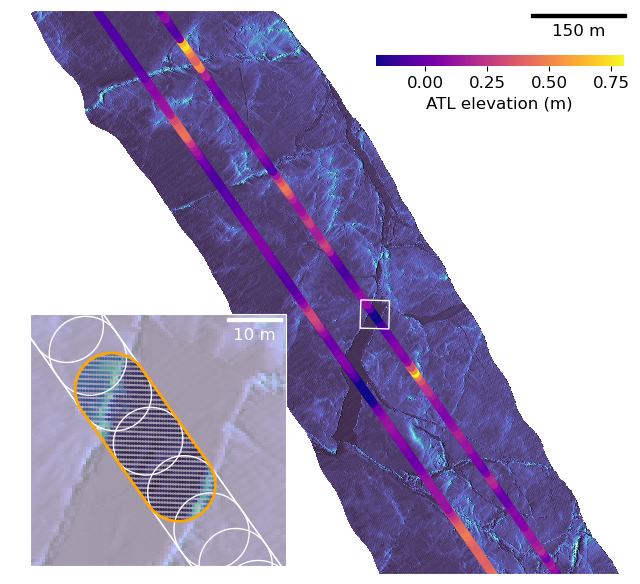

In [28]:
mpl.rc_file_defaults()
ALSpath = "/Users/rricker/Data/IS2/tds-is2/l4-grid-v2/"
ALSlist = sorted(glob.glob(ALSpath + '*.nc'))
file= ALSlist[61:62][0]
ds = xr.open_dataset(file)
elev = np.array(ds.elevation)
dx, dy = 0.01773, 0.00094
dt = (np.array(ds.time)[0]-np.mean(ATL07_gdf.ATL_time)).total_seconds()+100.0
ds['xc']= ds.xc - (dt * dx)
ds['yc']= ds.yc - (dt * dy)

int_elev = elev
int_elev[np.isnan(int_elev)==True]=-2
ls = LightSource(azdeg=270,altdeg=35)

rgb = ls.shade(int_elev, cmap=cmocean.cm.deep_r, blend_mode='overlay',vert_exag=2.0, dx=ds.xc, dy=ds.yc)
rgb[int_elev==-2]=np.nan
shade = xr.DataArray(coords=[ds.yc, ds.xc,np.arange(4)], dims=["yc", "xc","band"])
shade["shade"]=(["yc", "xc","band"], rgb)

fig = plt.figure(figsize=(8, 8))
projection = ccrs.Stereographic(central_latitude=86.0, central_longitude=13.0, true_scale_latitude=70)
ax = plt.axes(projection=projection)

e_lon = np.array(ds.lon).flatten()[np.isnan(np.array(ds.elevation).flatten())!=True]
e_lat = np.array(ds.lat).flatten()[np.isnan(np.array(ds.elevation).flatten())!=True]

ax.set_extent([e_lon.min(), e_lon.max(), e_lat.min()+0.0017, e_lat.max()-0.0017])

ax.outline_patch.set_edgecolor('white')

shade.shade.plot.imshow(ax=ax,transform=projection)

data_gt2l = data_gt2l.to_crs(4326)
data_gt2r = data_gt2r.to_crs(4326)
data_gt2l[3252:3389].plot(ax=ax,column='ATL_elevation',cmap="plasma",
               aspect='equal',vmin=-0.2,vmax=0.8,transform=ccrs.PlateCarree())
data_gt2r[2306:2451].plot(ax=ax,column='ATL_elevation',cmap="plasma",
               aspect='equal',vmin=-0.2,vmax=0.8,transform=ccrs.PlateCarree())


box_xmin = 11.309
box_xmax = 11.316
box_ymin = 86.66165
box_ymax = 86.66205

x = [box_xmin, box_xmin, box_xmax, box_xmax]
y = [box_ymin, box_ymax, box_ymax, box_ymin]
roi = LinearRing(list(zip(x, y)))
ax.add_geometries([roi], ccrs.PlateCarree(), facecolor='none', edgecolor='white')

fontprops = fm.FontProperties(size=12)
scalebar = AnchoredSizeBar(ax.transData,
                           150, '150 m', 'upper right', 
                           pad=0.15,
                           sep=5,
                           color='black',
                           frameon=False,
                           size_vertical=4.0,
                           fontproperties=fontprops)

ax.add_artist(scalebar)

cax = ax.inset_axes([0.59, 0.9, 0.4, 0.02], transform=ax.transAxes)
cb = plt.colorbar(ax.collections[1],ax=ax,shrink=0.7,orientation='horizontal',cax=cax)
cb.set_label(label='ATL elevation (m)',size=12)
cb.ax.tick_params(labelsize=12)
cb.outline.set_linewidth(0)

ALS_footprint = data_gt2r.pointsinside[2372]
ALS_footprint.crs = 3413
ALS_footprint = ALS_footprint.to_crs(4326)

ax2 = fig.add_axes([0.15, 0.15, 0.32, 0.32],projection=projection)
ax2.set_extent([box_xmin, box_xmax, box_ymin, box_ymax])
ax2.outline_patch.set_edgecolor('white')
shade.shade.plot.imshow(ax=ax2,transform=projection,alpha=0.5)
plt.scatter(ALS_footprint.geometry.x,
            ALS_footprint.geometry.y,
            c=data_gt2r.pointsinside[2372].elevation,s=1,transform=ccrs.PlateCarree(),cmap=cmocean.cm.deep_r)

data_gt2r[2366:2377].geometry.boundary.plot(color='white',edgecolor='k',linewidth = 1,
                                            ax=ax2,aspect='equal',transform=ccrs.PlateCarree())

data_gt2r[2372:2373].geometry.boundary.plot(color='orange',edgecolor='k',linewidth = 2,
                                            ax=ax2,aspect='equal',transform=ccrs.PlateCarree())

fontprops = fm.FontProperties(size=12)
scalebar = AnchoredSizeBar(ax2.transData,
                           10, '10 m', 'upper right', 
                           pad=0.15,
                           sep=5,
                           color='white',
                           frameon=False,
                           size_vertical=0.5,
                           fontproperties=fontprops)
ax2.add_artist(scalebar)

plt.savefig(out_path + 'Overview2_1.png',dpi=300,bbox_inches='tight' )


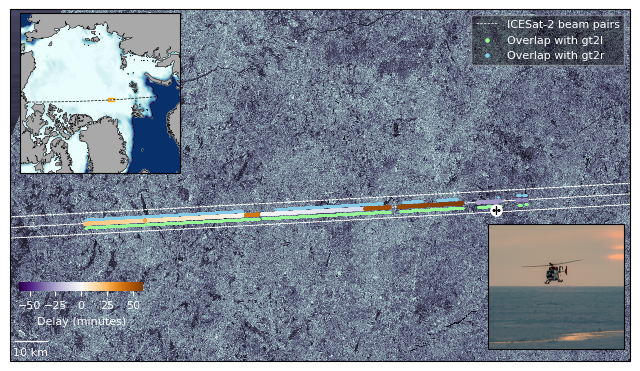

In [75]:
# overview figure 
mpl.rc_file_defaults()
xrange = (1100,4800)
yrange = (2800,4900)

bg_im = signal.detrend(s1[0][yrange[0]:yrange[1],xrange[0]:xrange[1]])
crs=ccrs.Stereographic(central_latitude=90.0, central_longitude=-45.0, false_easting=0.0, false_northing=0.0, true_scale_latitude=70.0)

ice_conc = netCDF4.Dataset("/Users/rricker/Data/IS2/ice_conc_nh_polstere-100_multi_202003231200.nc")
im = Image.open('/Users/rricker/Data/IS2/Heli.jpg')

tmp = {
"ice_conc": np.ma.getdata(ice_conc.variables["ice_conc"]).data[0,:,:],
"flag": np.ma.getdata(ice_conc.variables["status_flag"]).data[0,:,:],
"lon": np.ma.getdata(ice_conc.variables["lon"]).data,
"lat": np.ma.getdata(ice_conc.variables["lat"]).data}
tmp['xc'], tmp['yc'] = reproject(tmp["lon"], tmp["lat"], 'epsg:4326', 'epsg:3413')
tmp["ice_conc"][tmp["ice_conc"]<=0]=np.nan
dt_data_gt2l = data_gt2l.ALS_time-data_gt2l.ATL_time

xmin = s1.x[xrange[0]:xrange[1]].min()
xmax = s1.x[xrange[0]:xrange[1]].max()
ymin = s1.y[yrange[0]:yrange[1]].min()
ymax = s1.y[yrange[0]:yrange[1]].max()

fig=plt.figure(figsize=(8, 8))
ax = plt.axes(projection=crs)
ax.set_extent([xmin, xmax, ymin, ymax], crs=crs)

ax.pcolormesh(s1.x[xrange[0]:xrange[1]],s1.y[yrange[0]:yrange[1]],bg_im, cmap='bone',zorder=1)

atl07 = ax.plot(ATL07_gdf.longitude,ATL07_gdf.latitude,transform=ccrs.PlateCarree(),linewidth=0.5,
                linestyle='--',zorder=2,color='white',label='ICESat-2 beam pairs')

gt2l = ax.scatter(data_gt2l.longitude-0.15,data_gt2l.latitude-0.0075,transform=ccrs.PlateCarree(),
                  color='palegreen',marker='.',s=0.21,zorder=3,label='Overlap with gt2l')
gt2r = ax.scatter(data_gt2r.longitude+0.15,data_gt2r.latitude+0.0075,transform=ccrs.PlateCarree(),
                  color='skyblue',marker='.',s=0.21,zorder=4,label='Overlap with gt2r')

gt2l_delay = ax.scatter(data_gt2l.longitude,data_gt2l.latitude,c=dt_data_gt2l.dt.total_seconds()/60.0,vmin=-60,vmax=60,
                        transform=ccrs.PlateCarree(),cmap='PuOr_r',s=2,zorder=5)

ps = ax.plot([15.81100],[86.21143], marker='o',ms=8.0,transform=ccrs.PlateCarree(),zorder=6,color='white')
ps = ax.plot([15.81100],[86.21143], marker='+',ms=6.0,transform=ccrs.PlateCarree(),zorder=6,color='black')

ax2 = fig.add_axes([0.138, 0.51, 0.2, 0.2],projection=crs)
ax2.set_facecolor(mpl.cm.get_cmap('Blues_r')(0.0))
ax2.pcolormesh(tmp['xc'],tmp['yc'],tmp['ice_conc'], cmap=cmocean.cm.ice,transform=crs)
ax2.plot(ATL07_gdf[ATL07_gdf.beam=='gt2l'].longitude[::1000],ATL07_gdf[ATL07_gdf.beam=='gt2l'].latitude[::1000],
         transform=ccrs.PlateCarree(),linewidth=0.5,linestyle='--',color='black')
ax2.set_extent([0, 180, 60, 90])
ax2.coastlines(linewidth=0.3)
ax2.add_feature(cartopy.feature.LAND,facecolor='darkgray')    
x = [xmin, xmin, xmax, xmax]
y = [ymin, ymax, ymax, ymin]
roi = LinearRing(list(zip(x, y)))
ax2.add_geometries([roi], crs, facecolor='none', edgecolor='orange')

ax3 = fig.add_axes([0.723, 0.283, 0.17, 0.17],projection=crs)
ax3.imshow(im)

fontprops = fm.FontProperties(size=8)
scalebar = AnchoredSizeBar(ax.transData,
                           1e4, '10 km', 'lower left', 
                           pad=0.2,
                           sep=5,
                           color='white',
                           frameon=False,
                           size_vertical=0.5,
                           fontproperties=fontprops)

ax.add_artist(scalebar)

cax = ax.inset_axes([0.015, 0.2, 0.2, 0.025], transform=ax.transAxes)
cb = plt.colorbar(gt2l_delay,ax=ax,orientation='horizontal',cax=cax)
cb.set_label(label='Delay (minutes)',size=8,color='white')
cb.ax.tick_params(labelsize=8,color='white')
cb.outline.set_linewidth(0)
cb.ax.xaxis.set_tick_params(color='white', labelcolor='white')
cb.locator = ticker.MaxNLocator(nbins=5)
cb.update_ticks()

leg = ax.legend(loc="upper right",fontsize=8,markerscale=10,labelcolor='white',
                facecolor='black',framealpha=0.4)

plt.savefig(out_path + 'Overview1.png',dpi=300,bbox_inches='tight' )


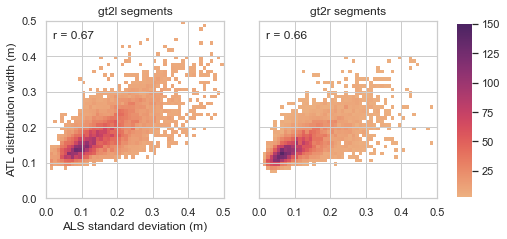

In [26]:
sns.set_theme(style="whitegrid")
ALS_hist_sdev, ATL_hist_w = get_stats(data_gt2l)
val_min, val_max = 0.0,0.5

heatmap, xedges, yedges = np.histogram2d(ALS_hist_sdev, ATL_hist_w, bins=50,range=[[val_min, val_max], [val_min, val_max]])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
heatmap.T[heatmap.T<3]=np.nan

fig, (ax1, ax2) = plt.subplots(1, 2,sharey=True,figsize=(7, 4))
ax1.imshow(heatmap.T, extent=extent, origin='lower',cmap=flare,vmin=0, vmax=150)
ax1.set_xticks(np.arange(0,0.6, 0.1))
ax1.set_yticks(np.arange(0,0.6, 0.1))
ax1.set_xlim([val_min, val_max])
ax1.set_ylim([val_min, val_max])
ax1.set_xlabel('ALS standard deviation (m)')
ax1.set_ylabel('ATL distribution width (m)')
ax1.text(0.02, 0.45, 'r = '+'%.2f' % np.corrcoef(np.array(ALS_hist_sdev), ATL_hist_w)[0,1], fontsize = 12)
ax1.title.set_text('gt2l segments')

ALS_hist_sdev, ATL_hist_w = get_stats(data_gt2r)
heatmap, xedges, yedges = np.histogram2d(ALS_hist_sdev, ATL_hist_w, bins=50,range=[[val_min, val_max], [val_min, val_max]])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
heatmap.T[heatmap.T<3]=np.nan

im= ax2.imshow(heatmap.T, extent=extent, origin='lower',cmap=flare,vmin=None, vmax=150)
ax2.set_xticks(np.arange(0,0.6, 0.1))
ax2.set_yticks(np.arange(0,0.6, 0.1))
ax2.set_xlim([val_min, val_max])
ax2.set_ylim([val_min, val_max])
ax2.text(0.02, 0.45, 'r = '+'%.2f' % np.corrcoef(np.array(ALS_hist_sdev), ATL_hist_w)[0,1], fontsize = 12)
ax2.title.set_text('gt2r segments')

cax = plt.axes([0.94, 0.2, 0.03, 0.6])
cb = plt.colorbar(im,cax=cax)
cb.outline.set_linewidth(0)

plt.savefig(out_path + 'Segment_stats.png',dpi=300,bbox_inches='tight' )


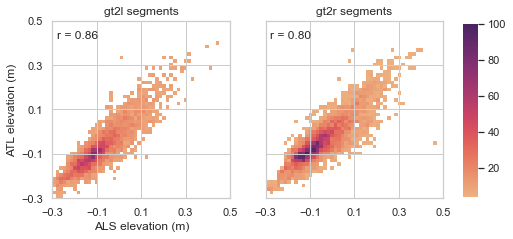

In [43]:
flare = sns.color_palette("flare", as_cmap=True)
sns.set_theme(style="whitegrid")

df = data_gt2r
correction_ALS, correction_ATL = remove_undulations(df,720)
x = np.array(df.ALS_elevation-correction_ALS)
y = np.array(df.ATL_elevation-correction_ATL)
valid = np.where(np.isnan(x)==False)[0]
xn = x[valid]
yn = y[valid]

val_min, val_max = -0.3,0.5

heatmap, xedges, yedges = np.histogram2d(xn,yn , bins=50,range=[[val_min, val_max], [val_min, val_max]])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
heatmap.T[heatmap.T<4]=np.nan
fig, (ax1, ax2) = plt.subplots(1, 2,sharey=True,figsize=(7, 4))
ax1.imshow(heatmap.T, extent=extent, origin='lower',cmap=flare,vmin=0, vmax=100)
ax1.set_xticks(np.arange(-0.3,0.9, 0.2))
ax1.set_yticks(np.arange(-0.3,0.9, 0.2))
ax1.set_xlim([val_min, val_max])
ax1.set_ylim([val_min, val_max])
ax1.set_xlabel('ALS elevation (m)')
ax1.set_ylabel('ATL elevation (m)')
ax1.text(-0.28, 0.42, 'r = '+'%.2f' % np.corrcoef(xn, yn)[0,1], fontsize = 12)
ax1.title.set_text('gt2l segments')

df = data_gt2l
correction_ALS, correction_ATL = remove_undulations(df,720)
x = np.array(df.ALS_elevation-correction_ALS)
y = np.array(df.ATL_elevation-correction_ATL)
valid = np.where(np.isnan(x)==False)[0]
xn = x[valid]
yn = y[valid]

heatmap, xedges, yedges = np.histogram2d(xn,yn , bins=50,range=[[val_min, val_max], [val_min, val_max]])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
heatmap.T[heatmap.T<4]=np.nan
im= ax2.imshow(heatmap.T, extent=extent, origin='lower',cmap=flare,vmin=None, vmax=100)
ax2.set_xticks(np.arange(-0.3,0.9, 0.2))
ax2.set_yticks(np.arange(-0.3,0.9, 0.2))
ax2.set_xlim([val_min, val_max])
ax2.set_ylim([val_min, val_max])
ax2.text(-0.28, 0.42, 'r = '+'%.2f' % np.corrcoef(xn, yn)[0,1], fontsize = 12)
ax2.title.set_text('gt2r segments')

cax = plt.axes([0.94, 0.2, 0.03, 0.6])
cb = plt.colorbar(im,cax=cax)
cb.outline.set_linewidth(0)

plt.savefig(out_path + 'Eleveation_comparison.png',dpi=300,bbox_inches='tight' )


In [47]:
ALS_seg_gt2r, ATL_seg_gt2r, ALS_all_gt2r = set_violin_plot(data_gt2r)
ALS_seg_gt2l, ATL_seg_gt2l, ALS_all_gt2l = set_violin_plot(data_gt2l)

ALS_seg = set_violin_plot_merge_beams(ALS_seg_gt2l,ALS_seg_gt2r,'ALS seg')
ATL_seg = set_violin_plot_merge_beams(ATL_seg_gt2l,ATL_seg_gt2r,'ATL seg')
ALS_all = set_violin_plot_merge_beams(ALS_all_gt2l,ALS_all_gt2r,'ALS full')

tmp=[ALS_seg,ATL_seg,ALS_all]
data = pd.concat([gdf for gdf in tmp]).pipe(gpd.GeoDataFrame)

del ALS_seg,ATL_seg,ALS_all,ALS_all_gt2r,ALS_all_gt2l,ATL_seg_gt2r,ATL_seg_gt2l,ALS_seg_gt2r,ALS_seg_gt2l

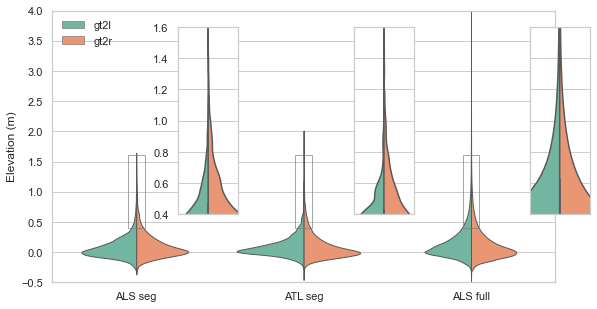

In [48]:
sns.set_theme(style="whitegrid")

fig=plt.figure(figsize=(9, 5))
ax=sns.violinplot(x='Label',y='Data',data=data,scale='area',scale_hue=False,gridsize=200,
                  split=True,hue="Beam",linewidth=1,inner=None,palette="Set2")
ax.legend(loc='upper left', frameon=False)
ax.set_ylim([-0.5, 4])
ax.set_xlabel('')
ax.set_ylabel('Elevation (m)')

# Create inset axes to zoom in on violinplot 
axins1 = ax.inset_axes([0.25, 0.25, 0.12, 0.69])
sns.violinplot(data=data[(data['Label']=='ALS seg')], x='Label', y="Data", hue="Beam",
               palette="Set2", split=True, scale="area",
               scale_hue=False, bw=.2, ax=axins1)

axins2 = ax.inset_axes([0.6, 0.25, 0.12, 0.69])
sns.violinplot(data=data[(data['Label']=='ATL seg')], x='Label', y="Data", hue="Beam",
               palette="Set2", split=True, scale="area",
               scale_hue=False, bw=.2, ax=axins2)

axins3 = ax.inset_axes([0.95, 0.25, 0.12, 0.69])
sns.violinplot(data=data[(data['Label']=='ALS full')], x='Label', y="Data", hue="Beam",
               palette="Set2", split=True, scale="area",
               scale_hue=False, bw=.2, ax=axins3)

axins1.set_xlim(-0.05,0.05)
axins1.set_ylim(0.4, 1.6)
axins1.set_xlabel('')
axins1.set_ylabel('')
axins1.set_xticklabels('')
axins1.legend().remove()

rect, lines = ax.indicate_inset_zoom(axins1, alpha=0.7)
for line in lines:
    line.remove()

axins2.set_xlim(-0.05,0.05)
axins2.set_ylim(0.4, 1.6)
axins2.set_xlabel('')
axins2.set_ylabel('')
axins2.set_xticklabels('')
axins2.set_yticklabels('')
axins2.legend().remove()

rect, lines = ax.indicate_inset_zoom(axins2, alpha=0.7)
rect.set_bounds(0.95,0.4,0.1, 1.2)
for line in lines:
    line.remove()

axins3.set_xlim(-0.05,0.05)
axins3.set_ylim(0.4, 1.6)
axins3.set_xlabel('')
axins3.set_ylabel('')
axins3.set_xticklabels('')
axins3.set_yticklabels('')
axins3.legend().remove()

rect, lines = ax.indicate_inset_zoom(axins3, alpha=0.7)
rect.set_bounds(1.95,0.4,0.1, 1.2)
for line in lines:
    line.remove()

plt.savefig(out_path + 'Violin_plots.png',dpi=300,bbox_inches='tight' )

In [226]:
df = data_gt2l
correction_ALS, correction_ATL = remove_undulations(df)
ALS_seg = np.array(df.ALS_elevation-correction_ALS)
ATL_seg = np.array(df.ATL_elevation-correction_ATL)
tmp=[]
for i in range(0,len(df)):
    tmp.append(df.pointsinside[i].elevation-correction_ALS[i])
    
valid = np.where(np.isnan(ALS_seg)==False)[0]
ALS_seg = ALS_seg[valid] 
ATL_seg = ATL_seg[valid] 
ALS_full = [np.nanmean(np.sort(tmp[i])[-10:]) for i in valid]

(-0.5, 4.0)

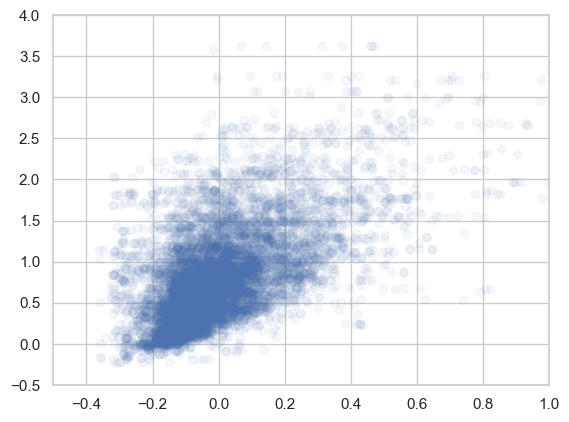

In [227]:
plt.scatter(ATL_seg,ALS_full,alpha=0.05)
plt.xlim(-0.5,1)
plt.ylim(-0.5,4)
